# Project 4 -  Classification and Regression, from linear and logistic regression to neural networks

The main aim of this project is to study both classification and
regression problems by developing your own feed-forward neural network (FFNN) code. You can reuse the regression algorithms studied so far. You will also include logistic regression for classification problems and write your own FFNN code for studying
both regression and classification problems.  The codes developed in lab 5, including bootstrap **and/or** cross-validation as well as the computation of the mean-squared error and/or the $R2$ or the accuracy score (classification problems) functions can
also be utilized in the present project. 

**Important Note**: This project as well as all following projects  have to be written as a scientific report. The instructions on how to do this and how we grade are given in a separate report. Please do spend some time to read our guidelines.

The data sets that we propose here are (the default sets)

* Regression (fitting a continuous function) 

In this part you use Regression to approximate (fit) a continuous function. For this exercise you will generate a dataset for a function
$\mathrm{FrankeFunction}(x,y)$ with $x,y \in [0,1]$. The function
$f(x,y)$ is the Franke function. You should explore also the addition
of an added stochastic noise to this function using the normal
distribution $N(0,1)$. 

The Franke function is described bellow:

 \begin{align*}
f(x,y) &= \frac{3}{4}\exp{\left(-\frac{(9x-2)^2}{4} - \frac{(9y-2)^2}{4}\right)}+\frac{3}{4}\exp{\left(-\frac{(9x+1)^2}{49}- \frac{(9y+1)}{10}\right)} \\
&+\frac{1}{2}\exp{\left(-\frac{(9x-7)^2}{4} - \frac{(9y-3)^2}{4}\right)} -\frac{1}{5}\exp{\left(-(9x-4)^2 - (9y-7)^2\right) }.
\end{align*}





* Classification 

Here you will also need to develop a Logistic regression code that you will use to compare with the Neural Network code. The data set we propose are the so-called [Wisconsin Breat Cancer Data](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data) data set of images representing various features of tumors.  A longer explanation with links to the scientific literature can be found at the [Machine Learning repository of the University of California at Irvine](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29). Feel free to consult this site and the pertinent  literature.

You can find more information about this at the [Scikit-Learn site](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html) or at the [University of California at Irvine](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)). 

The University of California at Irvine with its Machine Learning repository at <https://archive.ics.uci.edu/ml/index.php> is an excellent site to look up for examples and inspiration. [Kaggle.com](https://www.kaggle.com/) is an equally interesting site. Feel free to explore these sites.


You will start with a regression problem starting  writing your own Stochastic Gradient Descent (SGD) code. 

### Part a): Write your own Stochastic Gradient Descent  code, first step

In order to get started, you will now replace in your standard ordinary
least squares (OLS) and Ridge regression codes (see previous labs) the matrix inversion
algorithm with your own SGD code. You can choose whether you want to
add the momentum SGD optionality or other SGD variants such as RMSprop
or ADAgrad or ADAM.

Perform an analysis of the results for OLS and Ridge regression as
function of the chosen learning rates, the number of mini-batches and
epochs as well as algorithm for scaling the learning rate. You can
also compare your own results with those that can be obtained using
for example **Scikit-Learn**'s various SGD options.  Discuss your
results. For Ridge regression you need now to study the results as functions of  the hyper-parameter $\lambda$ and 
the learning rate $\eta$.  Discuss your results.

You will need your SGD code for the setup of the Neural Network and Logistic Regression codes. You will find the Python [Seaborn package](https://seaborn.pydata.org/generated/seaborn.heatmap.html) useful when plotting the results as function of the learning rate $\eta$ and the hyper-parameter $\lambda$ when you use Ridge regression.

\begin{align*}
f(x,y) &= \frac{3}{4}\exp{\left(-\frac{(9x-2)^2}{4} - \frac{(9y-2)^2}{4}\right)}+\frac{3}{4}\exp{\left(-\frac{(9x+1)^2}{49}- \frac{(9y+1)}{10}\right)} \\
&+\frac{1}{2}\exp{\left(-\frac{(9x-7)^2}{4} - \frac{(9y-3)^2}{4}\right)} -\frac{1}{5}\exp{\left(-(9x-4)^2 - (9y-7)^2\right) }.
\end{align*}

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def FrankeFunction_noisy(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    noise = np.random.normal(0, 0.1, len(x)) 
    return (term1 + term2 + term3 + term4 + noise)

def generate_data(n=40):
    x = np.sort(np.random.uniform(0, 1, n))
    y = np.sort(np.random.uniform(0, 1, n))
    x,y = np.meshgrid(x,y)
    y=y.reshape(len(x)**2)
    x=x.reshape(len(x)**2)
    return(np.array([x,y,FrankeFunction_noisy(x,y)]).T)

In [2]:
data=generate_data(n=40)
print(data.shape)
data

(1600, 3)


array([[ 0.02753821,  0.00853309,  0.80769895],
       [ 0.06567823,  0.00853309,  0.9097736 ],
       [ 0.1409092 ,  0.00853309,  0.71627891],
       ...,
       [ 0.96755888,  0.9671133 ,  0.05526244],
       [ 0.97634151,  0.9671133 ,  0.04808271],
       [ 0.98661342,  0.9671133 , -0.03256542]])

In [3]:
X=data[:,0:2]
y=data[:,2]
X.shape

(1600, 2)

In [4]:
class Regressor():
    
    # init methodd initializes all parameters needed to implement regression
    def __init__(self, epochs=200, learning_rate=0.1, seed=None,normalize=False):
        self.W = None
        self.b = None
        #self.polynomial=polynomial
        self.epochs = epochs
        self.lr = learning_rate
        self.length = None
        self.normalize = normalize
        self.m = None
        self.costs = []
        self.iterations = []
        np.random.seed(seed if seed is not None else np.random.randint(100))
    
    # random initialization of weights and bias
    def initialize_weights_and_bias(self):
        self.W = np.random.randn(self.length) #(n,1)
        self.b = 0
    
    # compute the error function: sum of squared errors 
    def computeCost(self,h,Y):
        loss = np.square(h-Y)
        cost = np.sum(loss)/(2*self.m)
        return cost

    # normalize the dataset by subtracting the mean and dividing by std deviation
    def normalizeX(self,X):
        #for power in range(1,self.polynomial):
        #    X=np.concatenate((X, np.power(X[:,0:2], power+1)), axis=1)
        #print(X.shape,self.mean)
        return (X-self.mean) / (self.std)
    
    # plot the iterations vs cost curves
    def plot(self,figsize=(7,5)):
        #plt.figure(figsize=figsize)
        plt.plot(self.iterations,self.costs)
    
    # test the model on test data
    def predict(self,X):
        if self.normalize: X = self.normalizeX(X)
        return np.dot(X,self.W)+self.b 
        
    
    # calculates the accuracy
    def score(self,X,y):
        return 1-(np.sum(((y-self.predict(X))**2))/np.sum((y-np.mean(y))**2))


In [5]:
class SGD_Linear_Regression(Regressor):
    
    def __init__(self,Ridge=0, epochs=200, learning_rate=0.1, seed=None,normalize=False):
        super().__init__(epochs, learning_rate, seed,normalize)
        self.l2_penality=Ridge
        
    def next_batch(self, features, labels, batch_size):
        # iterate though a mini batch of both our features and labels
        for data in range(0, np.shape(features)[0], batch_size):
            yield (features[data: data+batch_size], labels[data: data+batch_size])
    
    def optimize(self,X,Y):
        h = np.dot(X,self.W)+self.b
        dW = (np.dot( X.T, (h-Y) ) + self.l2_penality * self.W) / self.m
        db = np.sum( h-Y )  / self.m
        self.W = self.W - self.lr*dW
        self.b = self.b - self.lr*db
        
    # fit the model to the dataset: training process
    def fit(self, X, y, batch_size = X.shape[0], verbose=False):
        
        if self.normalize:
            self.mean, self.std = X.mean(axis=0), X.std(axis=0)
            X = self.normalizeX(X)
            
        self.m,self.length = X.shape
        self.initialize_weights_and_bias()
        i = 0
        
        while self.epochs>i:
            
            i += 1
            cost_list=[]
            
            for (X_batch, y_batch) in self.next_batch(X, y, batch_size):
                
                h = np.dot(X_batch,self.W)+self.b
                cost = self.computeCost(h,y_batch)
                cost_list.append(cost)
                
                if verbose and i % 5 ==0:
                    print(f"Iteration: {i}, Cost: {np.average(cost_list):.3f}")

                self.optimize(X_batch,y_batch)
                self.costs.append(cost)
                self.iterations.append(i)

In [6]:
class ADAM_Linear_Regression(Regressor):
    
    def __init__(self,Ridge=0, epochs=200, learning_rate=0.1, seed=None,normalize=False):
        super().__init__(epochs, learning_rate, seed,normalize)
        self.l2_penality=Ridge
        
    def next_batch(self, features, labels, batch_size):
        # iterate though a mini batch of both our features and labels
        for data in range(0, np.shape(features)[0], batch_size):
            yield (features[data: data+batch_size], labels[data: data+batch_size])
    
    def optimize(self,X,Y,t,beta1,beta2,eps):
        h = np.dot(X,self.W)+self.b
        dW = (np.dot( X.T, (h-Y) ) + self.l2_penality * self.W) / self.m
        db = np.sum( h-Y )  / self.m
        
        
        self.m_dw = beta1*self.m_dw + (1-beta1)*dW
        # *** biases *** #
        self.m_db = beta1*self.m_db + (1-beta1)*db

        ## rms beta 2
        # *** weights *** #
        self.v_dw = beta2*self.v_dw + (1-beta2)*(dW**2)
        # *** biases *** #
        self.v_db = beta2*self.v_db + (1-beta2)*(db**2)

        ## bias correction
        m_dw_corr = self.m_dw/(1-beta1**t)
        m_db_corr = self.m_db/(1-beta1**t)
        v_dw_corr = self.v_dw/(1-beta2**t)
        v_db_corr = self.v_db/(1-beta2**t)

        ## update weights and biases
        self.W = self.W - self.lr*(m_dw_corr/(np.sqrt((v_dw_corr))+eps))
        self.b = self.b - self.lr*(m_db_corr/(np.sqrt((v_db_corr))+eps))
        
    # fit the model to the dataset: training process
    def fit(self, X, y, beta1=0.88, beta2=0.99, eps=1e-8, batch_size = X.shape[0], verbose=False):
         
        if self.normalize:
            self.mean, self.std = X.mean(axis=0), X.std(axis=0)
            X = self.normalizeX(X)
            
        self.m,self.length = X.shape
        self.initialize_weights_and_bias()
        i = 0
        
        self.m_dw = np.zeros(X.shape[1])
        self.m_db=0
        self.v_dw = np.zeros(X.shape[1])
        self.v_db=0
        
        while self.epochs>i:
            
            i += 1
            cost_list=[]
            
            for (X_batch, y_batch) in self.next_batch(X, y, batch_size):
                
                h = np.dot(X_batch,self.W)+self.b
                cost = self.computeCost(h,y_batch)
                cost_list.append(cost)
                
                if verbose and i % 5 ==0:
                    print(f"Iteration: {i}, Cost: {np.average(cost_list):.3f}")
                
                self.optimize(X,y,i,beta1,beta2,eps)
                self.costs.append(cost)
                self.iterations.append(i)

In [7]:
L1 = SGD_Linear_Regression(Ridge=30,epochs=50,learning_rate=0.1,normalize=True)
L1.fit( X, y,batch_size=128, verbose=True)
print(L1.score(X,y))

L2 = ADAM_Linear_Regression(Ridge=30,epochs=50,learning_rate=0.1,normalize=True)
L2.fit( X, y ,batch_size=128, verbose=True)
print(L2.score(X,y))


Iteration: 5, Cost: 0.039
Iteration: 5, Cost: 0.037
Iteration: 5, Cost: 0.035
Iteration: 5, Cost: 0.032
Iteration: 5, Cost: 0.030
Iteration: 5, Cost: 0.027
Iteration: 5, Cost: 0.024
Iteration: 5, Cost: 0.022
Iteration: 5, Cost: 0.020
Iteration: 5, Cost: 0.019
Iteration: 5, Cost: 0.018
Iteration: 5, Cost: 0.017
Iteration: 5, Cost: 0.016
Iteration: 10, Cost: 0.010
Iteration: 10, Cost: 0.011
Iteration: 10, Cost: 0.011
Iteration: 10, Cost: 0.011
Iteration: 10, Cost: 0.011
Iteration: 10, Cost: 0.010
Iteration: 10, Cost: 0.009
Iteration: 10, Cost: 0.008
Iteration: 10, Cost: 0.008
Iteration: 10, Cost: 0.007
Iteration: 10, Cost: 0.007
Iteration: 10, Cost: 0.006
Iteration: 10, Cost: 0.006
Iteration: 15, Cost: 0.003
Iteration: 15, Cost: 0.004
Iteration: 15, Cost: 0.005
Iteration: 15, Cost: 0.005
Iteration: 15, Cost: 0.005
Iteration: 15, Cost: 0.005
Iteration: 15, Cost: 0.004
Iteration: 15, Cost: 0.004
Iteration: 15, Cost: 0.004
Iteration: 15, Cost: 0.003
Iteration: 15, Cost: 0.003
Iteration: 15,

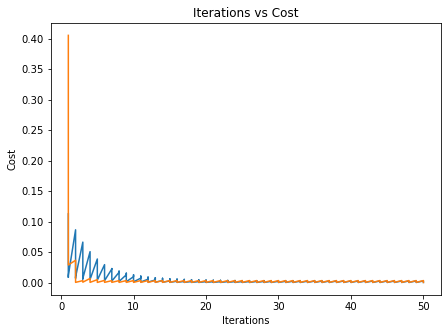

In [8]:
plt.figure(figsize=(7,5))
L1.plot()
L2.plot()
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title("Iterations vs Cost")
plt.show()

### Part b): Writing your own Neural Network code

Your aim now, and this is the central part of this project, is to
write your own Feed Forward Neural Network  code implementing the back
propagation algorithm discussed in the lecture slides.

You will focus on a regression problem first and study  the
Franke function. Discuss again your choice of cost function.

Write an FFNN code for regression with a flexible number of hidden
layers and nodes using the Sigmoid function as activation function for
the hidden layers. Initialize the weights using a normal
distribution. How would you initialize the biases? And which
activation function would you select for the final output layer?

Train your network and compare the results with those from your OLS and Ridge Regression codes from previous labs and projects. You should test your results against a similar code using **Scikit-Learn**  or **tensorflow/keras**. 

Comment your results and give a critical discussion of the results
obtained with the Linear  Regression code and your own Neural Network
code.  
Make an analysis of the regularization parameters and the learning rates employed to find the optimal MSE and $R2$ scores.

A useful reference on the back propagation algorithm is [Nielsen's
book](http://neuralnetworksanddeeplearning.com/). It is an excellent
read.

In [9]:
X = np.reshape(X,(X.shape[0],1,X.shape[1]))
y = np.reshape(y,(y.shape[0],1,1))

In [10]:
#activation functions
def relu(x):
    return(np.maximum(0, x))

def relu_prime(x):
    return np.where(x > 0, 1.0, 0.0)

def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return (1 - np.square(np.tanh(x)))

def sigmoid(x):
    #print(x)
    return (1/(1 + np.exp(-x)))

def sigmoid_prime(x):
    return ((1 - sigmoid(x)) * sigmoid(x))

In [11]:
# Loss Functions 
def logloss(y, a):
    return (-(y*np.log(a) + (1-y)*np.log(1-a))).reshape(-1)

def logloss_prime(y, a):
    return ((a - y)/(a*(1 - a)))

def d_computeCost(h,Y,m):
    loss = np.square(h-Y)
    cost = -1/(4*m*loss)
    return cost

def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

In [12]:
class Layer:
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        # dBias = output_error

        # update parameters
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

In [13]:
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

In [14]:
class Network:
    def __init__(self):
        self.loss = None
        self.loss_prime = None
        self.layers = []
        self.costs = []
        self.iterations = []

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime
    
    def class_predict(self, input_data):
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)
        pred = [1 if p > 0.5 else 0 for p in result]
        return pred
    
    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result

    # train the network
    def fit(self, x_train, y_train, epochs, learning_rate):
        # sample dimension first
        samples = len(x_train)

        # training loop
        for i in range(epochs):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)
                #print(output,y_train[j])
                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)

                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            # calculate average error on all samples
            err /= samples
            #print(err)
            self.costs.append(err)
            self.iterations.append(i)
            if((i+1) % ((epochs)/4)  == 0 ):
                print('epoch %d/%d   error=%f' % (i+1, epochs, err))
    
    def plot(self,figsize=(7,5)):
        #plt.figure(figsize=figsize)
        plt.plot(self.iterations,self.costs)
    
    def class_score(self,X,y):
        pred = self.class_predict(X)
        h=y.reshape(-1)
        correct = pred == h
        #print(h)
        #print(correct)
        #print(np.sum(correct))
        return(np.sum(correct)/y.shape[0])
        
    def score(self,X,y):
        return 1-(np.sum(((y-self.predict(X))**2))/np.sum((y-np.mean(y))**2))

### Part c): Testing different activation functions

You should now also test different activation functions for the hidden layers. Try out the Sigmoid, the RELU and the Leaky RELU functions and discuss your results. You may also study the way you initialize your weights and biases.

In [15]:
net1 = Network()
net1.add(Layer(2, 3))
net1.add(ActivationLayer(sigmoid, sigmoid_prime))
net1.add(Layer(3, 1))
net1.add(ActivationLayer(sigmoid, sigmoid_prime))

# train
net1.use(mse, mse_prime)
net1.fit(X, y, epochs=40, learning_rate=0.1)
net1.score(X,y)


epoch 10/40   error=0.021332
epoch 20/40   error=0.020793
epoch 30/40   error=0.021004
epoch 40/40   error=0.020986


0.6400902246237021

In [16]:
net2 = Network()
net2.add(Layer(2, 3))
net2.add(ActivationLayer(relu, relu_prime))
net2.add(Layer(3, 1))
net2.add(ActivationLayer(relu, relu_prime))

# train
net2.use(mse, mse_prime)
net2.fit(X, y, epochs=40, learning_rate=0.1)
net2.score(X,y)
1-(np.sum(((y-net2.predict(X))**2))/np.sum((y-np.mean(y))**2))

epoch 10/40   error=0.015973
epoch 20/40   error=0.015939
epoch 30/40   error=0.015914
epoch 40/40   error=0.015912


-0.24029042435963355

0.6400902246237021


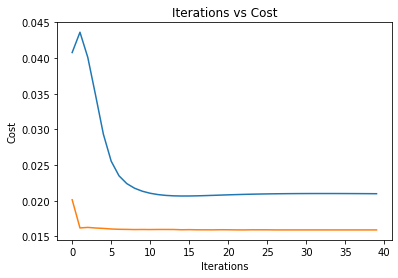

In [17]:
print(net1.score(X,y))
net1.plot()
net2.plot()
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title("Iterations vs Cost")
plt.show()

### Part d): Classification  analysis using neural networks

With a well-written code it should now be easy to change the
activation function for the output layer.

Here you will change the cost function for your neural network code
developed in parts b) and c) in order to perform a classification analysis. 

You will here study the Wisconsin Breast Cancer  data set. This is a typical binary classification problem with just one single output, either True or Fale, $0$ or $1$ etc.
You find more information about this at the [Scikit-Learn
site](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html) or at the [University of California
at Irvine](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)). 


To measure the performance of your classification problem  use the
so-called *accuracy* score.  The accuracy is as you would expect just
the number of correctly guessed targets $t_i$ divided by the total
number of targets, that is

$$
\text{Accuracy} = \frac{\sum_{i=1}^n I(t_i = y_i)}{n} ,
$$

where $I$ is the indicator function, $1$ if $t_i = y_i$ and $0$
otherwise if we have a binary classification problem. Here $t_i$
represents the target and $y_i$ the outputs of your FFNN code and $n$ is simply the number of targets $t_i$.

Discuss your results and give a critical analysis of the various parameters, including hyper-parameters like the learning rates and the regularization parameter $\lambda$ (as you did in Ridge Regression), various activation functions, number of hidden layers and nodes and activation functions.  


As stated in the introduction, it can also be useful to study other
datasets. 

Again, we strongly recommend that you compare your own neural Network
code for classification and pertinent results against a similar code using **Scikit-Learn**  or **tensorflow/keras** or **pytorch**.

In [26]:
def normalize(X, axis=0):
    return (X - np.mean(X, axis=axis)) / np.std(X, axis=axis)

In [27]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

data = load_breast_cancer()
x=data.data
y=data.target
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)

In [29]:
X = np.reshape(x_train,(x_train.shape[0],1,x_train.shape[1]))
y = np.reshape(y_train,(y_train.shape[0],1,1))
X = normalize(X)

epoch 250/1000   error=0.241832
epoch 500/1000   error=0.170599
epoch 750/1000   error=0.140571
epoch 1000/1000   error=0.122695


0.9648351648351648

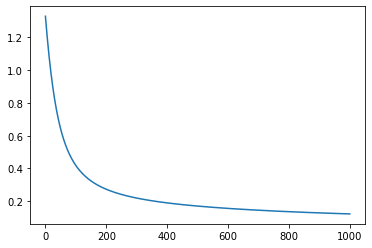

In [30]:
net3 = Network()
net3.add(Layer(30, 30))
net3.add(ActivationLayer(tanh, tanh_prime))
net3.add(Layer(30, 1))
net3.add(ActivationLayer(sigmoid, sigmoid_prime))
# train
net3.use(logloss, logloss_prime)
net3.fit(X, y, epochs=1000, learning_rate=1e-5)
net3.plot()
net3.class_score(X,y)

### Part e): Write your Logistic Regression code, final step

Finally, you want to compare the FFNN code you have developed with
Logistic regression, that is  wish to compare your neural network
classification results with the results you can obtain with another
method.

Define your cost function and the design matrix before you start writing your code.
Write thereafter a Logistic regression code using your SGD algorithm. You can also use standard gradient descent in this case, with a learning rate as hyper-parameter.
Study the results as functions of the chosen learning rates.
Add also an $l_2$ regularization parameter $\lambda$. Compare your results with those from your FFNN code as well as those obtained using **Scikit-Learn**'s logistic regression functionality.

The weblink  here <https://medium.com/ai-in-plain-english/comparison-between-logistic-regression-and-neural-networks-in-classifying-digits-dc5e85cd93c3>compares logistic regression and FFNN using the so-called MNIST data set. You may find several useful hints and ideas from this article. 

In [31]:
from sklearn.metrics import accuracy_score

data = load_breast_cancer()
x=data.data
y=data.target
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)

In [37]:
class LogisticRegression1():
    
    def __init__(self, num_epochs=30, lr=0.1 ):
        self.num_epochs = num_epochs
        self.lr = lr
        self.iterations=[]
        self.costs=[]
        self.weights = None 
        self.bias = None

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def __loss(self, y, A):
        #print(y,A)
        return - np.mean(y * np.log(A) + (1 - y) * np.log(1 - A))
    
    def predict(self, X):
        Z = np.dot(self.weights.T, X) + self.bias
        A = self.__sigmoid(Z)
        pred = [1 if p > 0.5 else 0 for p in A.reshape(-1)]
        return pred
    
    def score(self,X,y):
        pred = self.predict(X)
        correct = pred == y
        return(np.sum(correct)/y.shape[0])
        
    def fit(self, X, y):
        n, m = X.shape
        print(f'Number of features = {n}')
        print(f'Number of samples = {m}')

        self.weights = np.zeros((n, 1))
        self.bias = 0

        for epoch in range(1, self.num_epochs + 1):
            Z = np.dot(self.weights.T, X) + self.bias
            A = self.__sigmoid(Z)

            dZ = A - y
            dW = 1/m * np.dot(X, dZ.T)
            db = 1/m * np.sum(dZ)

            self.weights -= self.lr * dW
            self.bias -= self.lr * db
            
            J = self.__loss(y, A)
            
            self.iterations.append(epoch)
            self.costs.append(J)
            print(f'Epoch {epoch} - Loss = {J}')
    
    def plot(self,figsize=(7,5)):
        #plt.figure(figsize=figsize)
        plt.plot(self.iterations,self.costs)

print('pena')


pena


Number of features = 30
Number of samples = 455
Epoch 1 - Loss = 0.6931471805599453
Epoch 2 - Loss = 0.5275329541946171
Epoch 3 - Loss = 0.4411539191651298
Epoch 4 - Loss = 0.3877149832503959
Epoch 5 - Loss = 0.35076660649962127
Epoch 6 - Loss = 0.3233444795308034
Epoch 7 - Loss = 0.30197659295207335
Epoch 8 - Loss = 0.28472583015205505
Epoch 9 - Loss = 0.27042022254381454
Epoch 10 - Loss = 0.25830590737369774
Epoch 11 - Loss = 0.24787404024599496
Epoch 12 - Loss = 0.23876751359989715
Epoch 13 - Loss = 0.23072749770778866
Epoch 14 - Loss = 0.22356123058703917
Epoch 15 - Loss = 0.21712178539876908
Epoch 16 - Loss = 0.21129490554089936
Epoch 17 - Loss = 0.20599017537439546
Epoch 18 - Loss = 0.20113494084399966
Epoch 19 - Loss = 0.19667002552369775
Epoch 20 - Loss = 0.19254664910291563
Epoch 21 - Loss = 0.18872416952415333
Epoch 22 - Loss = 0.18516840078372507
Epoch 23 - Loss = 0.1818503404463783
Epoch 24 - Loss = 0.17874519362074123
Epoch 25 - Loss = 0.1758316147208653
Epoch 26 - Loss = 

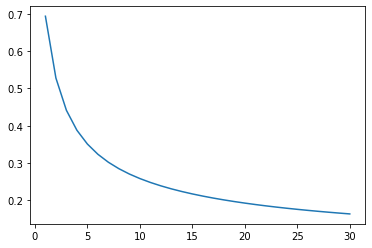

In [43]:
X = normalize(x_train)
X_t = normalize(x_test)
lr = LogisticRegression1()
lr.fit(X.T, y_train.T)
pred = lr.predict(X.T)
print(lr.score(X.T,y_train.T))
accuracy = accuracy_score(y_train.T, pred)
print(accuracy)
lr.plot()

### Part f) Critical evaluation of the various algorithms

After all these glorious calculations, you should now summarize the
various algorithms and come with a critical evaluation of their pros
and cons. Which algorithm works best for the regression case and which
is best for the classification case. These codes can also be part of
your final project.




## Background literature

1. The text of Michael Nielsen is highly recommended, see [Nielsen's book](http://neuralnetworksanddeeplearning.com/). It is an excellent read.

2. The textbook of [Trevor Hastie, Robert Tibshirani, Jerome H. Friedman, The Elements of Statistical Learning, Springer](https://www.springer.com/gp/book/9780387848570), chapters 3 and 7 are the most relevant ones for the analysis here. 

3. Deep learning with python by Jason Brownlee (available in piazza course material with python code)

4. Long Short Term Memory Networks with python by Jason Brownlee (available in piazza course material with python code)


## Introduction to numerical projects

Here follows a brief recipe and recommendation on how to write a report for each
project.

  * Give a short description of the nature of the problem and the eventual  numerical methods you have used.

  * Describe the algorithm you have used and/or developed. Here you may find it convenient to use pseudocoding. In many cases you can describe the algorithm in the program itself.

  * Include the source code of your program. Comment your program properly.

  * If possible, try to find analytic solutions, or known limits in order to test your program when developing the code.

  * Include your results either in figure form or in a table. Remember to        label your results. All tables and figures should have relevant captions        and labels on the axes.

  * Try to evaluate the reliabilty and numerical stability/precision of your results. If possible, include a qualitative and/or quantitative discussion of the numerical stability, eventual loss of precision etc.

  * Try to give an interpretation of you results in your answers to  the problems.

  * Critique: if possible include your comments and reflections about the  exercise, whether you felt you learn something, ideas for improvements and  other thoughts you've made when solving the exercise. We wish to keep this course at the interactive level and your comments can help us improve it.

  
## Format for electronic delivery of report and programs

* The preferred format for the report is a latex and PDF file.   As programming language we prefer that you choose between Python. The following prescription should be followed when preparing the report:

* You should upload your work on your team dropbox file.

* You should create GitHub/GitLab or similar typo of  repos!  For the source code file(s) you have developed please provide us with your link to your GitHub/GitLab or similar  domain.  The report file should include all of your discussions and a list of the codes you have developed.  

* In your GitHub/GitLab or similar repository, please include a folder which contains selected results. These can be in the form of output from your code for a selected set of runs and input parameters.



## Software and needed installations

If you have Python installed (we recommend Python3) and you feel pretty familiar with installing different packages, 
we recommend that you install the following Python packages via **pip** as
1. pip install numpy scipy matplotlib ipython scikit-learn tensorflow sympy pandas pillow

For Python3, replace **pip** with **pip3**.

See below for a discussion of **tensorflow** and **scikit-learn**. 

For OSX users we recommend also, after having installed Xcode, to install **brew**. Brew allows 
for a seamless installation of additional software via for example
1. brew install python3

For Linux users, with its variety of distributions like for example the widely popular Ubuntu distribution
you can use **pip** as well and simply install Python as 
1. sudo apt-get install python3  (or python for python2.7)

etc etc. 

If you don't want to install various Python packages with their dependencies separately, we recommend two widely used distributions which set up  all relevant dependencies for Python, namely
1. [Anaconda](https://docs.anaconda.com/) Anaconda is an open source distribution of the Python and R programming languages for large-scale data processing, predictive analytics, and scientific computing, that aims to simplify package management and deployment. Package versions are managed by the package management system **conda**

2. [Enthought canopy](https://www.enthought.com/product/canopy/)  is a Python distribution for scientific and analytic computing distribution and analysis environment, available for free and under a commercial license.

Popular software packages written in Python for ML are

* [Scikit-learn](http://scikit-learn.org/stable/), 

* [Tensorflow](https://www.tensorflow.org/),

* [PyTorch](http://pytorch.org/) and 

* [Keras](https://keras.io/).

These are all freely available at their respective GitHub sites. They 
encompass communities of developers in the thousands or more. And the number
of code developers and contributors keeps increasing.